# Data extraction and processing
see here for API tutorial on selecting data
http://docs.synapse.org/rest/org/sagebionetworks/repo/web/controller/TableExamples.html

In [2]:
# # %load sc2FitModels.py

In [404]:
import pandas as pd
import json
import numpy as np
import pickle #to save files
from scipy.stats import skew, kurtosis, pearsonr
from scipy.signal import butter, welch, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
import xgboost as xgb
from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
import nolds
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.core.debugger import Tracer

In [3]:
import synapseclient

In [4]:
syn=synapseclient.login()

Welcome, Luca Lonini!



### Helper fcns - Feature extraction and clip generation

In [358]:
#feature extraction
#INPUT: raw x,y,z accelerometer data (dataframe)
def feature_extraction(rawdata):
    
    #drop time and magnitude feature
    rawdata_wtime = rawdata.copy()
    rawdata=rawdata.iloc[:,1:4]
    
    features_list = ['EX','EY','EZ','rangeX','rangeY','rangeZ','meanX','meanY','meanZ','varX','varY','varZ',
                    'skewX','skewY','skewZ','kurtX','kurtY','kurtZ','xcor_peakXY','xcorr_peakXZ','xcorr_peakYZ',
                    'xcorr_lagXY','xcorr_lagXZ','xcorr_lagYZ','Dom_freq','Pdom_rel','PSD_mean','PSD_std','PSD_skew',
                    'PSD_kur','jerk_mean','jerk_std','jerk_skew','jerk_kur']
    

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    #extract features on current clip

    #Energy of signal on each axis
    E = np.asarray(np.sum(rawdata**2,axis=0))

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis
    mean = np.asarray(np.mean(rawdata,axis=0))
    var = np.asarray(np.std(rawdata,axis=0))
    sk = skew(rawdata)
    kurt = kurtosis(rawdata)

    #Cross-correlation between axes pairs
    xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
    xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
    xcorr_peak_xy = np.max(xcorr_xy)
    xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

    xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
    xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
    xcorr_peak_xz = np.max(xcorr_xz)
    xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

    xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
    xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
    xcorr_peak_yz = np.max(xcorr_yz)
    xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

    #pack xcorr features
    xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
    xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])
    
    #jerk moments on magnitude
    jerk = rawdata.iloc[:,-1].diff().values
    jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

    #Dominant freq and relative magnitude (on acc magnitude)
    Pxx = power_spectra_welch(rawdata_wtime,fm=1,fM=10)
    domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
    Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total
    
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.values),np.nanstd(Pxx.values),skew(Pxx.values),kurtosis(Pxx.values)])

    #sample entropy raw data and FFT - COMPUTATIONALLY EXPENSIVE - TAKE OUT FOR NOW
#     sH_raw = []; sH_fft = []
#     for a in range(3):
#         x = rawdata.iloc[:,a]
#         n = len(x) #number of samples in clip
#         Fs = np.mean(1/(np.diff(x.index)/1000)) #sampling rate in clip
#         sH_raw.append(nolds.sampen(x)) #samp entr raw data
#         f,Pxx_den = welch(x,Fs,nperseg=min(256,n/4))
#         sH_fft.append(nolds.sampen(Pxx_den)) #samp entr fft

    #Assemble features in array
    X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,Pxx_moments,jerk_moments))
#                 X = X.reshape(1,X.shape[0])
    features.append(X)

    F = np.asarray(features) #feature matrix for all clips from current trial
    return F,features_list


def gen_clips(rawdata,clipsize=5,overlap=0,interp=True):
    
    len_tol = 0.8   #% of the intended clipsize below which clip is not used (deprecated for now)
    #reindex time (relative to start)
    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    #create clips data
    deltat = np.median(np.diff(rawdata.timestamp))
    idx = np.arange(0,rawdata.timestamp.iloc[-1],clipsize*(1-overlap))
    clips = []
    for i in idx:
        c = rawdata[(rawdata.timestamp>=i) & (rawdata.timestamp<i+clipsize)]
        if interp:
            if len(c) == 250:
                clips.append(c)
            #resample clip if not enough samples are there
            elif (len(c) >200) & (len(c)<250): #for now hard code clip size (enforce 250 samples)
                t = c.timestamp.values
                tnew = np.linspace(t[0],t[-1],250)  
                x_res = resample(c.iloc[:,1].values,num,tnew)[0]
                y_res = resample(c.iloc[:,2].values,num,tnew)[0]
                z_res = resample(c.iloc[:,3].values,num,tnew)[0]
                mag_res = resample(c.iloc[:,4].values,num,tnew)[0]
                cres = pd.DataFrame(data=np.vstack((tnew,x_res,y_res,z_res,mag_res)).T,columns=list(c.columns))
                clips.append(cres)
        else:
            if len(c) > 10: #at least n data points in clip
                clips.append(c)
#         if len(c) > 0.8*int(clipsize/deltat): #discard clips whose length is less than len_tol% of the window size
    return clips

#returns power spectra of the signal over each channel between min and max freq at given resolution (nbins)
#returns the labels for each bin; #if nbins = -1 does not bin the data
#if binavg is True it averages the PSD within bins to reduce PSD noise
#**DO NOT USE - NEED TO FIX BUG*** 
def powerspectra(x,fm,fM,nbins=-1,relative=False,binavg=True):
    
    #feature labels (if binned)
    labels=[]
    if nbins > 0:
        s = np.linspace(fm,fM,nbins)
        lax = ['X','Y','Z']
        for l in lax:
            for i in s:
                labels.append('fft'+l+str(int(i)))
        
    #signal features
    n = len(x) #number of samples in clip
    Fs = np.nanmean(1/(np.diff(x.timestamp))) #sampling rate in clip
    timestep = 1/Fs 
    freq = np.fft.fftfreq(n,d=timestep) #frequency bins

    #run FFT on each channel 
    x = x.drop('timestamp',axis=1)
    Xf = x.apply(np.fft.fft)
    Xf.index = np.round(freq,decimals=1) #reindex w frequency bin
    Pxx = Xf.apply(np.abs)
    Pxx = Pxx**2 #power spectra
    
    if relative:
        Pxx = Pxx/np.sum(Pxx,axis=0) #power relative to total
        
    if nbins > 0:
        #power spectra between fm-fM Hz
        bin1 = int(timestep*n*fm)
        bin2 = int(timestep*n*fM)
        bins = np.linspace(bin1,bin2,nbins,dtype=int)
    #     print(bins/(round(timestep*n)))

        #average power spectra within bins - CHECK FOR BUG!
        if binavg:
            deltab = int(0.5*np.diff(bins)[0]) #half the size of a bin (in samples)
            Pxxm = []
            for i in bins:
                start = int(max(i-deltab,bins[0]))
                end = int(min(i+deltab,bins[-1]))
                Pxxm.append(np.nanmean(Pxx.iloc[start:end,:].values,axis=0))            
            Pxxm = np.asarray(Pxxm)
            Pxx = pd.DataFrame(data=Pxxm,index=Pxx.index[bins],columns=Pxx.columns)
            return Pxx, labels

        else:
            return Pxx.iloc[bins,:], labels
    #no binning
    else:
        return Pxx

    
#PSD on magnitude using Welch
def power_spectra_welch(rawdata,fm,fM):
    x = rawdata.iloc[:,-1]
    n = len(x) #number of samples in clip
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate in clip
    f,Pxx_den = welch(x,Fs,nperseg=min(256,n))
    #return PSD in desired interval of freq
    inds = (f<=fM)&(f>=fm)
    f=f[inds]
    Pxx_den=Pxx_den[inds]
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f,columns=['PSD_magnitude'])

    return Pxxdf

    
#highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer data from each visit (trial)
def filter_signal(rawdata,cutoff=0.75,ftype='highpass',order=4):

    t = rawdata.timestamp
    t = t-t.iloc[0]
    rawdata.timestamp = t
    x = rawdata.iloc[:,1:].values
    Fs = np.mean(1/(np.diff(rawdata.timestamp))) #sampling rate    
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
    b,a = butter(order,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    t = np.expand_dims(t,axis=1)
    rawdatafilt = pd.DataFrame(data=np.hstack((t,xfilt)),columns=rawdata.columns)
    return rawdatafilt


In [25]:
#X,y are numpy arrays with features and target
#returns mean feature importance
def LOSOCV(X,y,groups,models):

    subj = LeaveOneGroupOut() 

    #train multiple classifiers
    for m in models:
        Sens_all=[]; Spec_all=[]; acc_all=[]; acc_train=[] #sens and spec for current model and all subject
        fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))

            #compute Sens and Spec for current subject and classifier
            if np.sum(yte==1)>0:                    
                Sens = sum((ypred==1)&( yte==1))/sum(yte==1)
            else:
                print('no positive examples for current test subj')
                Sens = np.nan
            if np.sum(yte==0)>0:
                Spec = sum((ypred==0) & (yte==0))/sum(yte==0)
            else:
                Spec = np.nan
                print('no negative examples for current test subj')
            Sens_all.append(Sens); Spec_all.append(Spec)
            #compute accuracy
            acc = sum(ypred==yte)/len(yte)
            acc_all.append(acc)
            #save fimp
            fi_all.append(clf.feature_importances_)
        
        #mean across all subjects
        print(('%s, mean Acc on training set = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_train),2*np.nanstd(acc_train)/np.sqrt(len(acc_train))))
        print(('%s, mean Sens = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Sens_all),2*np.nanstd(Sens_all)/np.sqrt(len(Sens_all))))
        print(('%s, mean Spec = %.3f (+/- %0.3f)')%(model_name,np.nanmean(Spec_all),2*np.nanstd(Spec_all)/np.sqrt(len(Spec_all))))
        print(('%s, mean Acc = %.3f (+/- %0.3f)')%(model_name,np.nanmean(acc_all),2*np.nanstd(acc_all)/np.sqrt(len(acc_all))))

    return fi_all

In [7]:
syntable = syn.tableQuery("SELECT * from syn10495809")

In [5]:
table = syntable.asDataFrame()

In [6]:
table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5168 entries, 25819_22 to 30986_23
Data columns (total 11 columns):
dataFileHandleId     5168 non-null int64
device               5168 non-null object
patient              5168 non-null object
session              5168 non-null int64
site                 5168 non-null object
task                 5168 non-null object
visit                5168 non-null int64
deviceSide           5168 non-null object
tremorScore          3667 non-null float64
dyskinesiaScore      1556 non-null float64
bradykinesiaScore    3016 non-null float64
dtypes: float64(3), int64(3), object(5)
memory usage: 484.5+ KB


In [7]:
table.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1.0,NaN,1.0
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1.0,NaN,1.0
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2.0,NaN,1.0
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1.0,NaN,1.0
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0.0,NaN


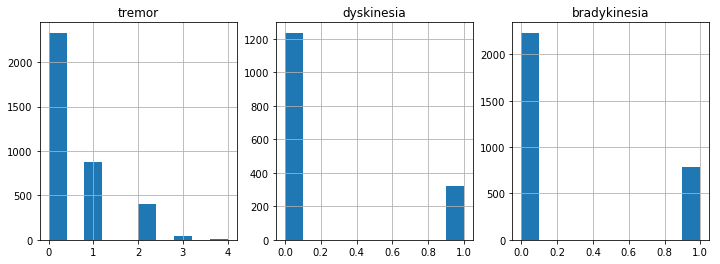

In [8]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131)
plt.title('tremor')
table.tremorScore.hist()
ax = fig.add_subplot(132)
table.dyskinesiaScore.hist()
plt.title('dyskinesia')
ax = fig.add_subplot(133)
table.bradykinesiaScore.hist()
plt.title('bradykinesia')

In [9]:
table.task.unique()

array(['drnkg', 'fldng', 'ftnl1', 'ftnl2', 'ftnr1', 'ftnr2', 'ntblt',
       'orgpa', 'raml1', 'raml2', 'ramr1', 'ramr2'], dtype=object)

In [10]:
sum(table.tremorScore==4)

12

# Bradykinesia

In [5]:
q_brady_train = syn.tableQuery("SELECT * from syn10495809 where bradykinesiaScore is not null")

In [6]:
paths_train = syn.downloadTableColumns(q_brady_train,'dataFileHandleId')

In [7]:
df_train = q_brady_train.asDataFrame()

In [8]:
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)

In [9]:
df_train.head(5)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...


In [10]:
df_train_brady = df_train

In [385]:
y_train = df_train['bradykinesiaScore'].values

In [386]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

## Train a baseline classifier using the metadata only

In [11]:
len(df_train.patient.unique())

19

In [182]:
X_meta = df_train[['dataFileHandleId','device','patient','session','site','task','visit','deviceSide']]
y_meta = df_train['bradykinesiaScore']

## Encode categorical variables with dummy values

In [183]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [184]:
X_meta.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left


In [185]:
X_meta_copy = X_meta.copy()
cat_cols = X_meta.select_dtypes(['object']).columns
for c in cat_cols:
    X_meta_copy[c]=le.fit_transform(X_meta[c])

In [186]:
X_meta_copy.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide
25819_22,17286028,0,2,1,0,0,1,1
25820_22,17286030,1,2,1,0,0,1,0
25821_22,17286034,0,2,1,0,1,1,1
25822_22,17286036,1,2,1,0,1,1,0
25824_22,17286042,1,2,1,0,2,1,0


In [187]:
X_meta=X_meta_copy

# Make dummy submission file to test score fcn

In [28]:
X_meta.to_csv('DummySubmission.csv',index=False)

In [29]:
%run sc2FitModels.py 'bradykinesia' DummySubmission.csv

Welcome, Luca Lonini!

AUPRC: 0.9898671060750107


## Explore data

dataFileHandleId                                              17286072
device                                                          Pebble
patient                                                         13_BOS
session                                                              1
site                                                            Boston
task                                                             orgpa
visit                                                                1
deviceSide                                                        Left
tremorScore                                                          1
dyskinesiaScore                                                    NaN
bradykinesiaScore                                                    1
path                 /Users/luca/Projects/DREAM_PD/Data/72/17286072...
Name: 25834_22, dtype: object


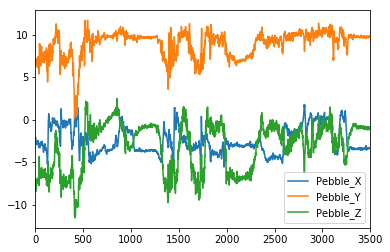

In [18]:
#plot task
idx=9
print(df_train.iloc[idx,:]) 
p1 = df_train.path[idx]
rawdata = pd.read_csv(p1,sep='\t')
rawdata.iloc[:,1:4].plot()

In [19]:
#durations of tasks
c = 0
Dur = []
for f in df_train.path:
    rawdata = pd.read_csv(f,sep='\t')
    t = rawdata.timestamp
    t = t-t[0]
    rawdata.timestamp = t
    Dur.append(rawdata.timestamp.iloc[-1])
    c+=1
Dur = np.asarray(Dur)

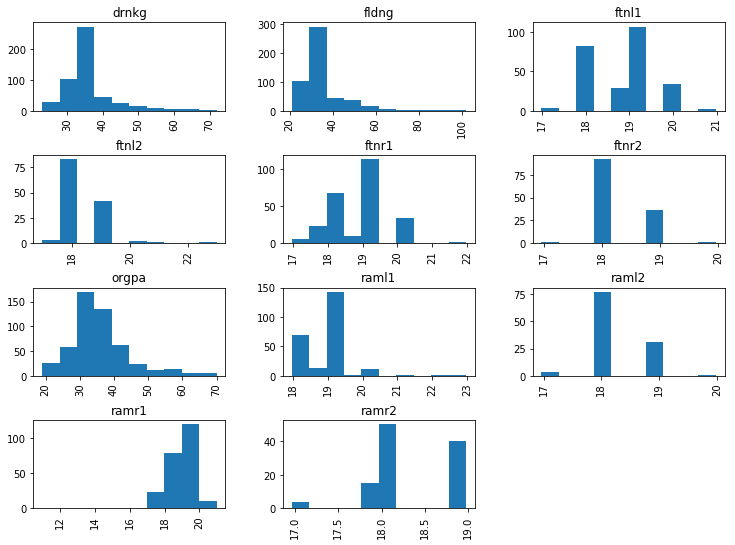

In [20]:
plt.figure(figsize=(12,4))
df_train['Duration']=Dur
ax = df_train.hist(column='Duration',by='task',figsize=(12,9))

In [21]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path,Duration
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...,38.98
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...,38.98
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...,101.98
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...,101.98
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...,17.98


In [22]:
#save dataframe with numerical metadata
df_train.to_csv('./DataFrames/df_train_brady.csv')

In [124]:
# #display duration based on presence of bradykinesia
# for t in df_train.task.unique():
#     fig = plt.figure()
#     for i in range(2):
#         d = df_train[(df_train['bradykinesiaScore']==i) & (df_train['task']==t)]
#         if ~d.empty:
#             try:
#                 sns.distplot(d['Duration'])
#             except(ZeroDivisionError):
#                 print(d.empty)
#     plt.title(t)

## Try Metadata features + Duration feature

In [24]:
X_meta['Duration']=df_train['Duration']

In [25]:
X_meta.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
25819_22,17286028,0,2,1,0,0,1,1,38.98
25820_22,17286030,1,2,1,0,0,1,0,38.98
25821_22,17286034,0,2,1,0,1,1,1,101.98
25822_22,17286036,1,2,1,0,1,1,0,101.98
25824_22,17286042,1,2,1,0,2,1,0,17.98


In [963]:
X = X_meta
scaler = StandardScaler()
X.iloc[:,-1]=scaler.fit_transform(X.iloc[:,8:])

In [965]:
X.to_csv('Meta_wDur.csv',index=False)

In [966]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Meta_wDur.csv

Welcome, Luca Lonini!

AUPRC: [0.94398336312474074, 0.1478882617202292, 0.94182279342107333, 0.96200299957554858, 0.77537483776358485, 0.99019019019019017, 0.99118165784832446, 0.9531456387497157, 0.41141654065110317, 0.98894009216589862, 0.34097351815805521, 0.4423668371328594, 0.18253298531557141, 0.90168575227823167, 0.75958758503401358, 0.4158965898076592, 0.95355067798597348, 0.28619378306878307, 0.98987841405218802]


In [840]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' DummySubmission.csv

Welcome, Luca Lonini!

AUPRC: [0.96418540805444453, 0.14027760685472601, 0.93497830075740962, 0.95911290159512474, 0.88405791313831983, 0.99019019019019017, 0.99118165784832446, 0.95310487912775166, 0.53794863427354733, 0.98894009216589862, 0.3443364414391421, 0.43842766253874399, 0.20572814485384885, 0.90425993036445451, 0.81553996598639455, 0.48223919859596359, 0.97285450032294607, 0.23109434865900383, 0.98636489479512734]


In [964]:
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration
25819_22,17286028,0,2,1,0,0,1,1,1.042534
25820_22,17286030,1,2,1,0,0,1,0,1.042534
25821_22,17286034,0,2,1,0,1,1,1,6.784089
25822_22,17286036,1,2,1,0,1,1,0,6.784089
25824_22,17286042,1,2,1,0,2,1,0,-0.871318


## Clips generation and feature extraction

### Test fcns

dataFileHandleId                                              17286028
device                                                       GENEActiv
patient                                                         13_BOS
session                                                              1
site                                                            Boston
task                                                             drnkg
visit                                                                1
deviceSide                                                       Right
tremorScore                                                          1
dyskinesiaScore                                                    NaN
bradykinesiaScore                                                    1
path                 /Users/luca/Projects/DREAM_PD/Data/28/17286028...
Duration                                                         38.98
Name: 25819_22, dtype: object


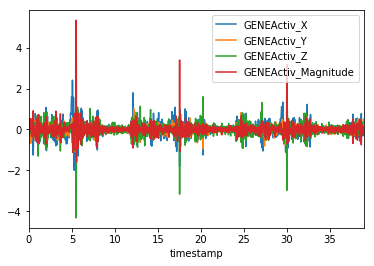

In [568]:
#plot task
idx=0
print(df_train.iloc[idx,:]) 
p1 = df_train.path[idx]
rawdata = pd.read_csv(p1,sep='\t')
rawdata = filter_signal(rawdata,order=2)
ax = rawdata.plot(x='timestamp')

In [138]:
# #TEST FEATURE EXTRACTION
# #cycle through all clips for current trial and save dataframe of features for current trial and sensor
# features = []

# #drop time and magnitude feature
# rawdata_wtime = rawdata.copy()
# rawdata=rawdata.iloc[:,1:4]


# #extract features on current clip

# #Energy of signal on each axis
# E = np.asarray(np.sum(rawdata**2,axis=0))

# #range on each axis
# min_xyz = np.min(rawdata,axis=0)
# max_xyz = np.max(rawdata,axis=0)
# r = np.asarray(max_xyz-min_xyz)

# #Moments on each axis
# mean = np.asarray(np.mean(rawdata,axis=0))
# var = np.asarray(np.std(rawdata,axis=0))
# sk = skew(rawdata)
# kurt = kurtosis(rawdata)

# #Cross-correlation between axes pairs
# xcorr_xy = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,1],mode='same')
# xcorr_xy = xcorr_xy/np.sum(xcorr_xy) #normalize values
# xcorr_peak_xy = np.max(xcorr_xy)
# xcorr_lag_xy = (np.argmax(xcorr_xy))/len(xcorr_xy) #normalized lag

# xcorr_xz = np.correlate(rawdata.iloc[:,0],rawdata.iloc[:,2],mode='same')
# xcorr_xz = xcorr_xz/np.sum(xcorr_xz) #normalize values
# xcorr_peak_xz = np.max(xcorr_xz)
# xcorr_lag_xz = (np.argmax(xcorr_xz))/len(xcorr_xz)

# xcorr_yz = np.correlate(rawdata.iloc[:,1],rawdata.iloc[:,2],mode='same')
# xcorr_yz = xcorr_yz/np.sum(xcorr_yz) #normalize values
# xcorr_peak_yz = np.max(xcorr_yz)
# xcorr_lag_yz = (np.argmax(xcorr_yz))/len(xcorr_yz)

# #pack xcorr features
# xcorr_peak = np.array([xcorr_peak_xy,xcorr_peak_xz,xcorr_peak_yz])
# xcorr_lag = np.array([xcorr_lag_xy,xcorr_lag_xz,xcorr_lag_yz])

# #jerk moments on magnitude
# jerk = np.asarray(rawdata.iloc[:,-1].diff())
# jerk_moments = np.array([np.nanmean(jerk),np.nanstd(jerk),skew(jerk[~np.isnan(jerk)]),kurtosis(jerk[~np.isnan(jerk)])])

# #Dominant freq and relative magnitude (on acc magnitude)
# Pxx = power_spectra_welch(rawdata_wtime,fm=1,fM=10)
# domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
# Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total

# #moments of PSD
# Pxx_moments = np.array([np.nanmean(Pxx.values),np.nanstd(Pxx.values),skew(Pxx.values),kurtosis(Pxx.values)])

# #Assemble features in array
# X = np.concatenate((E,r,mean,var,sk,kurt,xcorr_peak,xcorr_lag,domfreq,Pdom_rel,jerk_moments,Pxx_moments))
# #                 X = X.reshape(1,X.shape[0])
# features.append(X)

# F = np.asarray(features) #feature matrix for all clips from current trial

In [48]:
Pxx = power_spectra_welch(rawdata,fm=1,fM=10)
domfreq = np.asarray([Pxx.iloc[:,-1].argmax()]) 
Pdom_rel = Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum() #power at dominant freq rel to total

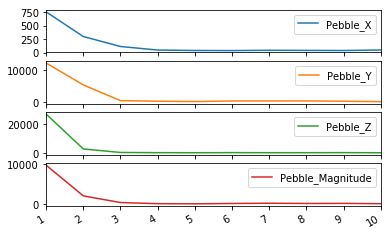

In [27]:
Pxx,fl=powerspectra(rawdata,1,10,nbins=10)
ax = Pxx.plot(subplots=True)

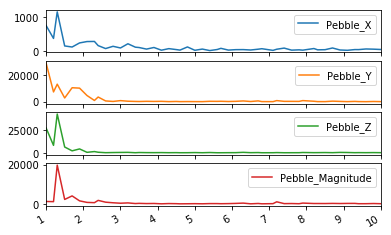

In [28]:
Pxx,fl=powerspectra(rawdata,1,10,nbins=50)
ax = Pxx.plot(subplots=True)

In [26]:
domfreq = np.asarray([Pxx.iloc[:,-1].argmax()])
domfreq

array([ 1.3])

In [27]:
Pxx.loc[domfreq].iloc[:,-1].values/Pxx.iloc[:,-1].sum()

array([ 0.47673788])

## Compute features on all rows and time it

#### Test on 1 row

In [133]:
F,flist = feature_extraction(rawdata)

In [134]:
F.shape

(1, 34)

In [139]:
row = 0
nans_found=0; n_empty=0
Features = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on entire recording
        try:
            F,flist = feature_extraction(rawdata)
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
3000
Elapsed Time:[s] 50.8
Files w nans: 190
Files w 0 non-nan rows 103
Tot rows: 3016


In [140]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

(3016, 34)


## Compute features on windows and take stats over windows

In [692]:
row = 0
nans_found=0; n_empty=0
max_nans = []
Features = []; 
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on each clip and stats over clips
        try:
            Fclips=[]
            clips = gen_clips(rawdata,overlap=0) #take clips
            for clip in clips:
                F,flist = feature_extraction(clip)
                Fclips.append(F) #the features from all the clips
            #stack mean and std over clips
            flist = flist+['s_'+n for n in flist] #update feature list w std
            Fmean = np.mean(Fclips,axis=0)
            Fstd = np.std(Fclips,axis=0)
            F = np.hstack((Fmean,Fstd))
            if F.size != 52:
                print(F.shape)
                sys.exit()
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
            
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
3000
Elapsed Time:[s] 134.1
Files w nans: 190
Files w 0 non-nan rows 103
Tot rows: 3016


(array([ 44.,   8.,   7.,   5.,   4.,   2.,   2.,   5.,   7.,   3.]),
 array([  4.87804878e-04,   9.77467167e-02,   1.95005629e-01,
          2.92264540e-01,   3.89523452e-01,   4.86782364e-01,
          5.84041276e-01,   6.81300188e-01,   7.78559099e-01,
          8.75818011e-01,   9.73076923e-01]),
 <a list of 10 Patch objects>)

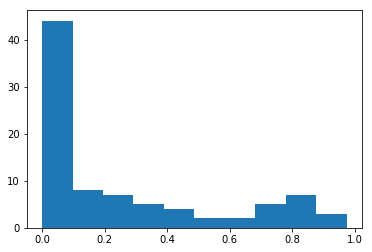

In [630]:
plt.hist(np.asarray(max_nans))

In [696]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

(3016, 52)


### append feature to df_train

In [141]:
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat.index = df_train.index
df_train = pd.concat((df_train,df_feat),axis=1)

In [188]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,...,Dom_freq,Pdom_rel,PSD_mean,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,...,1.562500,0.043495,0.003869,0.001502,0.245445,-0.344417,0.000017,0.360148,1.344217,51.836805
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,...,1.367187,0.143907,0.050698,0.072788,2.379819,5.293353,-0.000185,0.508781,0.701911,10.937510
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,...,2.343750,0.045680,0.042349,0.016684,1.081894,0.570791,-0.000019,0.410676,-0.106500,4.133854
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,...,1.562500,0.089059,0.039644,0.040317,1.566515,1.400621,0.000006,0.470394,-0.767359,13.588961
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,...,1.757812,0.303718,0.021948,0.050055,4.377813,20.632291,-0.000066,0.304035,-0.280895,0.818470


### Test performance

In [191]:
X = pd.concat((X_meta,df_train.iloc[:,12:]),axis=1) #12 includes duration - 13 starts from features

In [192]:
X['bradykinesiaScore']=df_train['bradykinesiaScore']

In [193]:
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration,EX,...,Pdom_rel,PSD_mean,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur,bradykinesiaScore
25819_22,17286028,0,2,1,0,0,1,1,38.98,261.944772,...,0.043495,0.003869,0.001502,0.245445,-0.344417,0.000017,0.360148,1.344217,51.836805,1
25820_22,17286030,1,2,1,0,0,1,0,38.98,1140.053894,...,0.143907,0.050698,0.072788,2.379819,5.293353,-0.000185,0.508781,0.701911,10.937510,1
25821_22,17286034,0,2,1,0,1,1,1,101.98,2710.009059,...,0.045680,0.042349,0.016684,1.081894,0.570791,-0.000019,0.410676,-0.106500,4.133854,1
25822_22,17286036,1,2,1,0,1,1,0,101.98,2380.027757,...,0.089059,0.039644,0.040317,1.566515,1.400621,0.000006,0.470394,-0.767359,13.588961,1
25824_22,17286042,1,2,1,0,2,1,0,17.98,339.931766,...,0.303718,0.021948,0.050055,4.377813,20.632291,-0.000066,0.304035,-0.280895,0.818470,1


In [194]:
X.shape

(3016, 44)

In [195]:
X.columns

Index(['dataFileHandleId', 'device', 'patient', 'session', 'site', 'task',
       'visit', 'deviceSide', 'Duration', 'EX', 'EY', 'EZ', 'rangeX', 'rangeY',
       'rangeZ', 'meanX', 'meanY', 'meanZ', 'varX', 'varY', 'varZ', 'skewX',
       'skewY', 'skewZ', 'kurtX', 'kurtY', 'kurtZ', 'xcor_peakXY',
       'xcorr_peakXZ', 'xcorr_peakYZ', 'xcorr_lagXY', 'xcorr_lagXZ',
       'xcorr_lagYZ', 'Dom_freq', 'Pdom_rel', 'PSD_mean', 'PSD_std',
       'PSD_skew', 'PSD_kur', 'jerk_mean', 'jerk_std', 'jerk_skew', 'jerk_kur',
       'bradykinesiaScore'],
      dtype='object')

In [196]:
X=X.dropna()

In [197]:
#drop target col
y = X['bradykinesiaScore'].values
X = X.drop('bradykinesiaScore',axis=1)

** Standardize features **

In [198]:
#standardize features
scaler = StandardScaler()
X.iloc[:,8:]=scaler.fit_transform(X.iloc[:,8:])

In [199]:
X.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,Duration,EX,...,Dom_freq,Pdom_rel,PSD_mean,PSD_std,PSD_skew,PSD_kur,jerk_mean,jerk_std,jerk_skew,jerk_kur
25819_22,17286028,0,2,1,0,0,1,1,1.022774,-0.460739,...,-0.545353,-1.170413,-0.729816,-0.622104,-1.911450,-0.983782,0.010024,-0.847169,1.285868,0.546600
25820_22,17286030,1,2,1,0,0,1,0,1.022774,-0.406806,...,-0.673378,0.172239,-0.631879,-0.531417,0.065927,-0.141123,-0.111706,-0.685110,0.717222,-0.154402


In [200]:
#Save a copy for later use
X_copy = X.copy()

## Check feature importance with XGBoost classifier

In [154]:
#LOSO CV
groups = X.patient.as_matrix()

In [155]:
models = [XGBClassifier()]
model_name = ['XGB']
models = list(zip(models,model_name))

In [156]:
X = X.drop('patient',axis=1)

In [ ]:
fimp_all = LOSOCV(X.iloc[:,1:].as_matrix(),y,groups,models)

In [713]:
fimp_all=np.asarray(fimp_all)

In [714]:
fimp_mean=np.mean(fimp_all,axis=0)

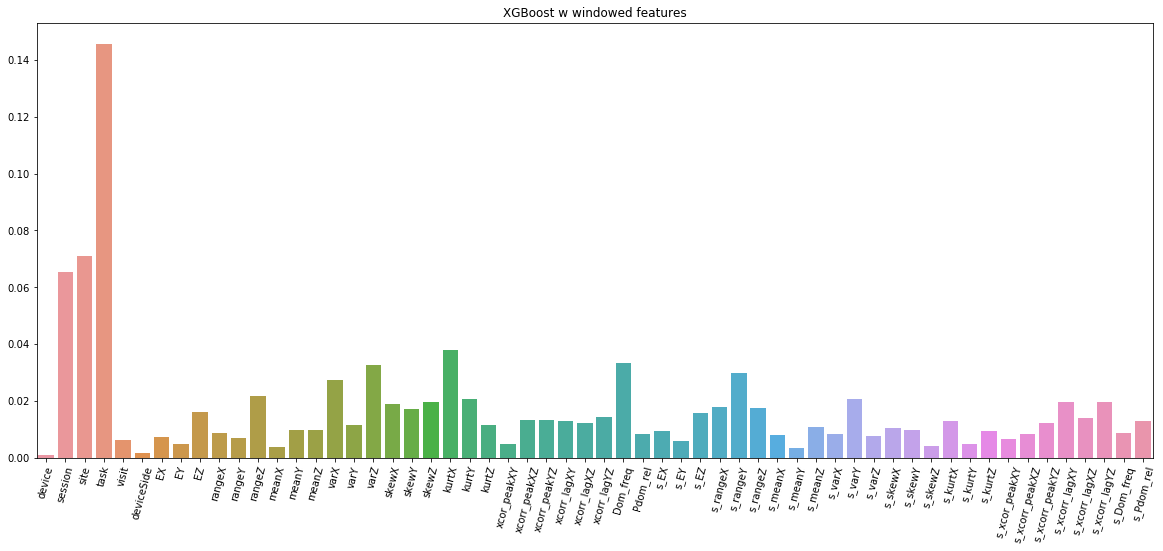

In [715]:
clf = models[0][0]
fimp = pd.Series(index=X.columns[1:],data=fimp_mean)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('XGBoost w windowed features')

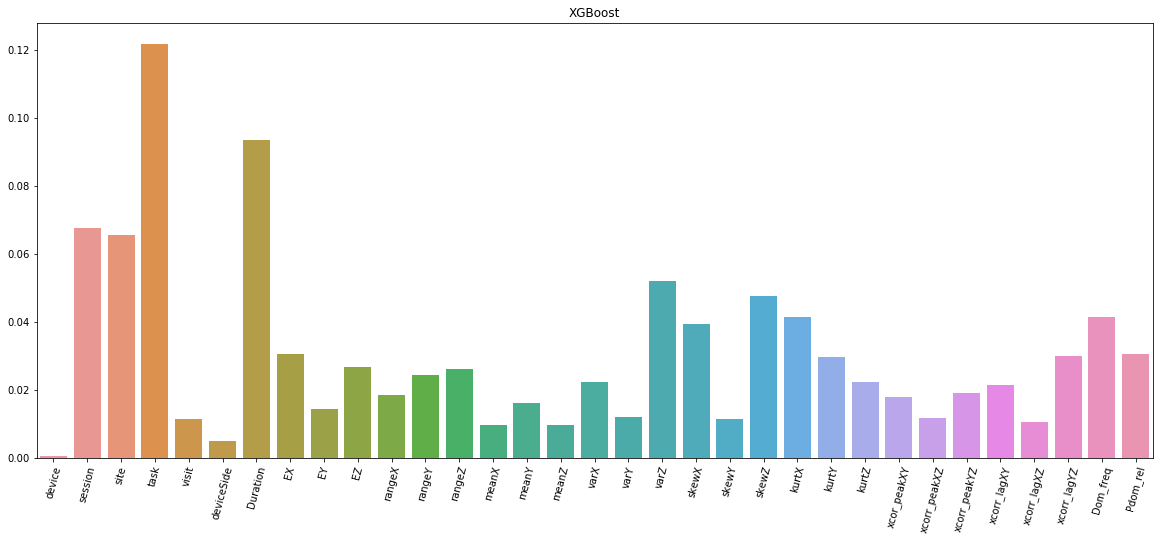

In [169]:
clf = models[0][0]
fimp = pd.Series(index=X.columns[1:],data=fimp_mean)
plt.figure(figsize=(20,8))
ax = sns.barplot(x=fimp.index,y=fimp.values)
_ = plt.xticks(rotation=75)
plt.title('XGBoost')

## Deep nets

In [206]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.core import Permute, Reshape
from keras import backend as K

Using Theano backend.


In [740]:
# useful functions
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':

        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))

    return X_train, X_valid

def model_variant(model, network_type):
    print(network_type)
    if network_type == 'ConvLSTM':


        model.add(Permute((2, 1, 3))) # for swap-dimension
        model.add(Reshape((-1,feat_map_num*dim)))
        model.add(LSTM(32, return_sequences=False, stateful=False))
        model.add(Dropout(0.5))
    if network_type == 'CNN':

        model.add(Flatten())
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.5))


def model_conv(model):
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5),
                 activation='relu',
                 input_shape=(dim, win_len, 1),
                 padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(feat_map_num, kernel_size=(1, 5), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(1, 2)))
    model.add(Dropout(0.5))

def model_LSTM(model):
    model.add(LSTM(64,
               input_shape=(win_len,dim),
               return_sequences=True,
               stateful=False))
    model.add(Dropout(0.5))
    model.add(LSTM(64, return_sequences=False, stateful=False))
    model.add(Dropout(0.5))

def model_MLP(model,num1,drop1,num2,drop2):
    model.add(Dense(num1, activation='relu', input_shape=(dim*win_len,)))
    model.add(Dropout(drop1))
    model.add(Dense(num2, activation='relu'))
    model.add(Dropout(drop2))


In [698]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path,Duration
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/28/17286028...,38.98
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/30/17286030...,38.98
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/34/17286034...,101.98
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1,/Users/luca/Projects/DREAM_PD/Data/36/17286036...,101.98
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1,/Users/luca/Projects/DREAM_PD/Data/42/17286042...,17.98


In [699]:
#gen raw data clips and store them in format (clip,time,channel)
row = 0
nans_found=0; n_empty=0
max_nans = []
t1 = time.time()
# data = np.empty((1,250,3)) #empty array storing all clips data (for nowassumes 5 sec clips sampled at 50 Hz)
data = []
targetscore = [] #store target score
subj = [] #store subj for CV 
task = [] #store task

for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        if np.sum(rawdata.isnull()).max() < len(rawdata):
            max_nans.append((np.sum(rawdata.isnull()).max())/len(rawdata))
        rawdata = rawdata.dropna() #drop nans
        
    #attempt extracting clips if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #extract and concatenate clips data
        clips = gen_clips(rawdata,overlap=0.5) #take clips over recording
        for clip in clips:
            datac = np.expand_dims(clips[0].iloc[:,1:4].values,axis=0)
            data.append(datac)
            targetscore.append(df_train.iloc[i].bradykinesiaScore) #the score for the current clip
            subj.append(X_meta.iloc[i].patient)
            task.append(X_meta.iloc[i].task)
#             data=np.concatenate((data,datac),axis=0)
            
    else:
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)
print('Tot rows: %d'%row)

0
1000
2000
3000
Elapsed Time:[s] 75.6
Files w nans: 190
Files w 0 non-nan rows 103
Tot rows: 3016


In [700]:
#save clips
features = np.asarray(data).squeeze()

In [701]:
features.shape

(28156, 250, 3)

In [702]:
#split into train, validation and test
len(subj)

28156

In [703]:
CNN_clips = {'X':features, 'y':np.asarray(targetscore),'Subj':subj,'Task':task}

In [704]:
CNN_clips['X'].shape

(28156, 250, 3)

In [705]:
#save clips
filename = 'CNNclips_train_bradyk.pkl'
f = open(filename,'wb')
pickle.dump(CNN_clips,f)
f.close()

In [753]:
#load clips
filename = 'CNNclips_train_bradyk.pkl'
f = open(filename, 'rb')
CNN_clips = pickle.load(f)
f.close()

In [754]:
X = CNN_clips['X']
y = CNN_clips['y']
groups = np.asarray(CNN_clips['Subj'])
task = np.asarray(CNN_clips['Task'])

In [708]:
#select only one task
ind = task==0
X=X[ind,:,:]
y=y[ind]
groups=groups[ind]

## standardize data by subject

In [755]:
#normalize by subject (mean 0, std 1)
Xscaler = StandardScaler()

for s in np.unique(groups):
    ind = groups==s
    for a in range(3):        
        X[ind,:,a]= Xscaler.fit_transform(X[ind,:,a])

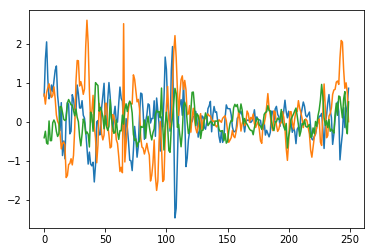

In [756]:
plt.plot(X[1000])

## Train a deep net (NLP or Convnet)

In [711]:
#perform a random train_valid split first to test approach
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.33,random_state=32)


In [712]:
y_valid.shape

(2122,)

In [713]:
y_train.shape

(4307,)

In [714]:
num_classes = 2 # 
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)


In [717]:
#specifying hyper-parameters
batch_size = 128
feat_map_num = 16
_, win_len, dim = X.shape
# network_type = 'CNN'
network_type = 'MLP'

In [718]:
print('reshaping data for different models ...')
X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)


reshaping data for different models ...
MLP


In [736]:
print('building the model ...')
model = Sequential()
if network_type=='CNN' or network_type=='ConvLSTM':
    model_conv(model)
    model_variant(model, network_type)
if network_type=='LSTM':
    model_LSTM(model)
if network_type=='MLP':
    model_MLP(model)
model.add(Dense(num_classes, activation='softmax'))
model.summary()


building the model ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_270 (Dense)            (None, 4)                 3004      
_________________________________________________________________
dropout_207 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_271 (Dense)            (None, 4)                 20        
_________________________________________________________________
dropout_208 (Dropout)        (None, 4)                 0         
_________________________________________________________________
dense_272 (Dense)            (None, 2)                 10        
Total params: 3,034
Trainable params: 3,034
Non-trainable params: 0
_________________________________________________________________


In [721]:
print('model training ...')
epochs = 20
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True,
          validation_data=(X_valid, y_valid))


model training ...
Train on 4307 samples, validate on 2122 samples
Epoch 1/20
4307/4307 [==============================] - 0s - loss: 0.3610 - acc: 0.8786 - val_loss: 0.2080 - val_acc: 0.9029
Epoch 2/20
4307/4307 [==============================] - 0s - loss: 0.2161 - acc: 0.9057 - val_loss: 0.1244 - val_acc: 0.9581
Epoch 3/20
4307/4307 [==============================] - 0s - loss: 0.1344 - acc: 0.9396 - val_loss: 0.0651 - val_acc: 0.9892
Epoch 4/20
4307/4307 [==============================] - 0s - loss: 0.0852 - acc: 0.9675 - val_loss: 0.0328 - val_acc: 0.9953
Epoch 5/20
4307/4307 [==============================] - 0s - loss: 0.0598 - acc: 0.9821 - val_loss: 0.0168 - val_acc: 1.0000
Epoch 6/20
4307/4307 [==============================] - 0s - loss: 0.0353 - acc: 0.9921 - val_loss: 0.0095 - val_acc: 1.0000
Epoch 7/20
4307/4307 [==============================] - 0s - loss: 0.0251 - acc: 0.9944 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 8/20
4307/4307 [==============================] - 0s

In [722]:
#performance eval
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_valid), axis=1)
y_true = np.argmax(y_valid, axis=1)
print('calculating confusion matrix ... ')
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))


calculating confusion matrix ... 
[[1881    0]
 [   0  241]]
the mean f1 score:1.00


In [533]:
X_train.shape

(18864, 3, 250, 1)

In [534]:
#check that the mean of each data point is 0
# ax = plt.boxplot(np.mean(X_train,axis=1))

In [604]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 3, 250, 16)        96        
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 3, 125, 16)        0         
_________________________________________________________________
dropout_107 (Dropout)        (None, 3, 125, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 3, 125, 16)        1296      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 3, 62, 16)         0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 3, 62, 16)         0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 2976)              0         
__________

In [757]:
#Now Train model by splitting into train and validation based on subject
logo = LeaveOneGroupOut() 

for train_index, test_index in logo.split(X, y, groups):

    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    
    #normalize data
#     Xscaler = StandardScaler()
#     X_train=Xscaler.fit_transform(X_train)
#     X_valid=Xscaler.transform(X_valid)
    
    X_train, X_valid = _data_reshaping(X_train, X_valid, network_type)

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_valid = keras.utils.to_categorical(y_valid, num_classes)
    
    #build model
    print('building the model ...')
    model = Sequential()
    if network_type=='CNN' or network_type=='ConvLSTM':
        model_conv(model)
        model_variant(model, network_type)
    if network_type=='LSTM':
        model_LSTM(model)
    if network_type=='MLP':
        model_MLP(model,4,0.6,2,0.9)
    model.add(Dense(num_classes, activation='softmax'))

    print('model training ...')
    epochs = 5
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              shuffle=True,
              validation_data=(X_valid, y_valid))
    #EVAL
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    y_true = np.argmax(y_valid, axis=1)
    print('calculating confusion matrix ... ')
    cf_matrix = confusion_matrix(y_true, y_pred)
    print(cf_matrix)
    class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
    print('the mean f1 score:{:.2f}'.format(np.mean(class_wise_f1)))


MLP
building the model ...
model training ...
Train on 26678 samples, validate on 1478 samples
Epoch 1/5
26678/26678 [==============================] - 0s - loss: 0.6408 - acc: 0.7776 - val_loss: 0.5787 - val_acc: 0.8241
Epoch 2/5
26678/26678 [==============================] - 0s - loss: 0.5762 - acc: 0.7776 - val_loss: 0.5253 - val_acc: 0.8241
Epoch 3/5
26678/26678 [==============================] - 0s - loss: 0.5490 - acc: 0.7776 - val_loss: 0.5000 - val_acc: 0.8241
Epoch 4/5
26678/26678 [==============================] - 0s - loss: 0.5367 - acc: 0.7776 - val_loss: 0.4850 - val_acc: 0.8241
Epoch 5/5
26678/26678 [==============================] - 0s - loss: 0.5324 - acc: 0.7776 - val_loss: 0.4787 - val_acc: 0.8241
calculating confusion matrix ... 
[[1218    0]
 [ 260    0]]
the mean f1 score:0.45
MLP
building the model ...


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


model training ...
Train on 26591 samples, validate on 1565 samples
Epoch 1/5
26591/26591 [==============================] - 0s - loss: 0.6446 - acc: 0.7717 - val_loss: 0.5461 - val_acc: 0.9214
Epoch 2/5
26591/26591 [==============================] - 0s - loss: 0.5834 - acc: 0.7717 - val_loss: 0.4654 - val_acc: 0.9214
Epoch 3/5
26591/26591 [==============================] - 0s - loss: 0.5555 - acc: 0.7717 - val_loss: 0.4163 - val_acc: 0.9214
Epoch 4/5
26591/26591 [==============================] - 0s - loss: 0.5438 - acc: 0.7717 - val_loss: 0.3874 - val_acc: 0.9214
Epoch 5/5
26591/26591 [==============================] - 0s - loss: 0.5394 - acc: 0.7717 - val_loss: 0.3713 - val_acc: 0.9214
calculating confusion matrix ... 
[[1442    0]
 [ 123    0]]
the mean f1 score:0.48
MLP
building the model ...
model training ...
Train on 26264 samples, validate on 1892 samples
Epoch 1/5
26264/26264 [==============================] - 0s - loss: 0.7573 - acc: 0.7791 - val_loss: 0.6946 - val_acc: 0.54

KeyboardInterrupt: 

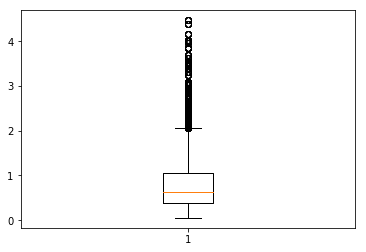

In [507]:
ax = plt.boxplot(np.std(X_train,axis=1))

## Submission

In [201]:
X = X_copy

In [204]:
X.to_csv('Submission_NewFeat.csv',index=False)

In [205]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_NewFeat.csv

Welcome, Luca Lonini!

AUPRC: 0.889


In [163]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_basicFeat.csv

Welcome, Luca Lonini!

AUPRC: 0.891


In [4]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Submission_winFeat.csv

Welcome, Luca Lonini!

AUPRC: 0.868


In [721]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Meta_wDur.csv

Welcome, Luca Lonini!

AUPRC: 0.823


In [716]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' DummySubmission.csv 

Welcome, Luca Lonini!

AUPRC: 0.814


In [875]:
coldrop=list(X.columns)[1:8]
coldrop.remove('patient')

In [877]:
X_featonly=X.drop(coldrop,axis=1)

In [878]:
X_featonly.to_csv('Featonly.csv',index=False)

In [879]:
%run sc2FitModels_LOSOCV.py 'bradykinesia' Featonly.csv

Welcome, Luca Lonini!

AUPRC: [0.92813597493628708, 0.10489913015856153, 0.93836956015802164, 0.95887173606110998, 0.79884693703799836, 0.95417932750479961, 0.87578096294956786, 0.51731107929267139, 0.16323291374897519, 0.89098782593317161, 0.1532074956641859, 0.19316931567203727, 0.093671750656162539, 0.81906306768680603, 0.060397277662888209, 0.35731165553082878, 0.96290579105755925, 0.01161578417073357, 0.97793564316195969]


** Feature computation time on 1 clip **

In [323]:
t1 = time.time()
rawdata = pd.read_csv(f,sep='\t')
print(time.time()-t1)
t1 = time.time()
F,flist = feature_extraction(rawdata)
print(time.time()-t1)


0.003940105438232422
0.009171009063720703


# Dyskinesia

In [9]:
q_dysk_train = syn.tableQuery("SELECT * from syn10495809 where dyskinesiaScore is not null")
paths_train = syn.downloadTableColumns(q_dysk_train,'dataFileHandleId')

In [10]:
df_train_dysk = q_dysk_train.asDataFrame()

In [11]:
df_train_dysk['path']=df_train_dysk.dataFileHandleId.astype(str).map(paths_train)

In [12]:
df_train_dysk.head(2)

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0,NaN,/Users/luca/Projects/DREAM_PD/Data/39/17286039...
25825_22,17286045,GENEActiv,13_BOS,1,Boston,ftnl2,1,Right,NaN,0,NaN,/Users/luca/Projects/DREAM_PD/Data/45/17286045...


In [886]:
df_train = df_train_dysk

In [887]:
row = 0
nans_found=0; n_empty=0
Features = []
t1 = time.time()
# for f in df_train.path:
for i in range(len(df_train)):

    f = df_train.iloc[i,:].path
    if row%1000==0:
        print(row)
    rawdata = pd.read_csv(f,sep='\t') #load file
   
    #remove nans
    rawdata = rawdata.astype('float64') #make sure everything is float
    if sum(np.sum(rawdata.isnull())) > 0:
        nans_found+=1 # of files w nans
        rawdata = rawdata.dropna() #drop nans
        
    #compute features if at least one data point is there
    if rawdata.empty != True:
        #reindex timestamp data relative to start 
        t = rawdata.timestamp
        t = t-t.iloc[0]
        rawdata.timestamp = t

        #HP filter data (remove gravity)
        rawdata = filter_signal(rawdata,order=2)

        #compute features on entire recording
        try:
            F,flist = feature_extraction(rawdata)
            Features.append(F)
        except(TypeError):
            print('found incompatible datatype')
    else:
        F = np.empty((1,len(flist))) #empty array of features
        F[:]=np.nan
        Features.append(F)
        n_empty+=1

    row+=1
        
elapsed = time.time()-t1
print('Elapsed Time:[s] %.1f'%elapsed)
print('Files w nans: %d'%nans_found)
print('Files w 0 non-nan rows %d'%n_empty)

0


/Users/luca/anaconda/envs/py35_pd20/lib/python3.5/site-packages/ipykernel/__main__.py:42: RuntimeWarning: Mean of empty slice


1000
Elapsed Time:[s] 38.7
Files w nans: 88
Files w 0 non-nan rows 56


In [891]:
Features = np.asarray(Features)
Features = Features.squeeze(axis=1)
print(Features.shape)

(1556, 26)


In [893]:
df_feat = pd.DataFrame(data=Features,columns=flist,dtype='float64')
df_feat.index = df_train.index
df_train = pd.concat((df_train,df_feat),axis=1)

In [894]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0,...,0.162701,-0.079857,4.745927,0.734146,0.546572,0.506667,0.503333,0.497778,8.1,0.072784
25825_22,17286045,GENEActiv,13_BOS,1,Boston,ftnl2,1,Right,NaN,0,...,0.134648,-0.026859,1.458933,1.109415,41.765466,0.515556,0.503333,0.496667,6.1,0.058848
25828_22,17286054,Pebble,13_BOS,1,Boston,ftnr1,1,Left,NaN,0,...,7.689771,1.385359,0.359814,0.669308,0.856794,0.505556,0.543333,0.485556,1.3,0.083133
25830_22,17286060,Pebble,13_BOS,1,Boston,ftnr2,1,Left,NaN,0,...,11.841003,3.249798,2.058724,1.980309,0.381623,0.498947,0.521053,0.500000,1.0,0.145483
25835_22,17286076,GENEActiv,13_BOS,1,Boston,raml1,1,Right,NaN,0,...,0.566197,0.002158,1.541055,2.828754,31.930616,0.482105,0.549474,0.557895,5.7,0.515168


In [911]:
X = df_train.copy()
cat_cols = df_train.select_dtypes(['object']).columns
for c in cat_cols:
    X[c]=le.fit_transform(df_train[c])

In [913]:
#drop scores cols
X = X.drop(['tremorScore','dyskinesiaScore','bradykinesiaScore','path'],axis=1)
#drop nans
X=X.dropna()

In [939]:
#normalize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X.iloc[:,8:]=scaler.fit_transform(X.iloc[:,8:])

In [940]:
X.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,EX,EY,...,kurtY,kurtZ,xcor_peakXY,xcorr_peakXZ,xcorr_peakYZ,xcorr_lagXY,xcorr_lagXZ,xcorr_lagYZ,Dom_freq,Pdom_rel
25823_22,17286039,0,2,1,0,0,1,1,-0.295024,-0.155948,...,-0.360872,-0.366179,-0.048514,-0.032020,-0.177740,0.156770,0.029291,-0.042929,1.964716,-0.667609
25825_22,17286045,0,2,1,0,1,1,1,-0.294555,-0.155654,...,-0.361554,-0.365204,-0.059190,-0.031821,0.641065,0.323521,0.029291,-0.061885,1.084997,-0.812262
25828_22,17286054,1,2,1,0,2,1,0,-0.291026,-0.150657,...,-0.177960,-0.339220,-0.062759,-0.032054,-0.171578,0.135926,0.667479,-0.251452,-1.026329,-0.560191
25830_22,17286060,1,2,1,0,3,1,0,-0.285960,-0.131261,...,-0.077083,-0.304915,-0.057242,-0.031361,-0.181017,0.011959,0.311997,-0.005015,-1.158287,0.086963
25835_22,17286076,0,2,1,0,4,1,1,-0.287749,-0.157567,...,-0.351067,-0.364670,-0.058923,-0.030912,0.445698,-0.303991,0.765446,0.982726,0.909053,3.924082


In [916]:
#only meta features
X_meta = X.iloc[:,1:7]

In [928]:
X_meta['dataFileHandleId'] = X['dataFileHandleId']

In [930]:
X_meta.to_csv('Submission_Dysk_meta.csv',index=False)

In [931]:
%run sc2FitModels.py 'dyskinesia' Submission_Dysk_meta.csv

Welcome, Luca Lonini!

AUPRC: 0.9871336130604139


In [941]:
X.to_csv('Submission_Dysk.csv',index=False)

In [942]:
%run sc2FitModels_LOSOCV.py 'dyskinesia' Submission_Dysk.csv

Welcome, Luca Lonini!

AUPRC: [0.17473357112568672, nan, 0.64130760600690595, nan, 0.75690683126336022, 0.96273329545072728, 0.35635302180995548, 0.33691768312514736, nan, 0.95759631691876423, nan, nan, nan, 0.088568145949117549, 0.042427884615384617, 0.12694342694342695, 0.005208333333333333, nan, 0.099259911942920886]


In [943]:
%run sc2FitModels.py 'dyskinesia' Submission_Dysk.csv

Welcome, Luca Lonini!

AUPRC: 0.9640081852084357


# Tremor

In [38]:
q_tremor = syn.tableQuery("SELECT * from syn10495809 where tremorScore is not null")

In [39]:
Train_tremor = q_tremor.asDataFrame()

In [40]:
Train_tremor.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1,NaN,1.0
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1,NaN,1.0
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2,NaN,1.0
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1,NaN,1.0
25824_22,17286042,Pebble,13_BOS,1,Boston,ftnl1,1,Left,2,NaN,1.0


In [56]:
data = {}
for file_handle_id, path in paths_train.items():
        with open(path) as f:
            data[file_handle_id] = f.read()

In [4]:
# q = syn.tableQuery("SELECT * from syn10495809 where tremorScore > 3")
q = syn.tableQuery("SELECT * from syn10495809 LIMIT 100")
paths_train = syn.downloadTableColumns(q,'dataFileHandleId')

In [5]:
df_train = q.asDataFrame()
df_train['path']=df_train.dataFileHandleId.astype(str).map(paths_train)

In [6]:
df_train.head()

,dataFileHandleId,device,patient,session,site,task,visit,deviceSide,tremorScore,dyskinesiaScore,bradykinesiaScore,path
25819_22,17286028,GENEActiv,13_BOS,1,Boston,drnkg,1,Right,1.0,NaN,1.0,Data/28/17286028/drnkg_GENEActiv.tsv
25820_22,17286030,Pebble,13_BOS,1,Boston,drnkg,1,Left,1.0,NaN,1.0,Data/30/17286030/drnkg_Pebble.tsv
25821_22,17286034,GENEActiv,13_BOS,1,Boston,fldng,1,Right,2.0,NaN,1.0,Data/34/17286034/fldng_GENEActiv.tsv
25822_22,17286036,Pebble,13_BOS,1,Boston,fldng,1,Left,1.0,NaN,1.0,Data/36/17286036/fldng_Pebble.tsv
25823_22,17286039,GENEActiv,13_BOS,1,Boston,ftnl1,1,Right,NaN,0.0,NaN,Data/39/17286039/ftnl1_GENEActiv.tsv


In [15]:
p1 = df_train.path[0]

In [20]:
rawdata = pd.read_csv(p1,sep='\t')

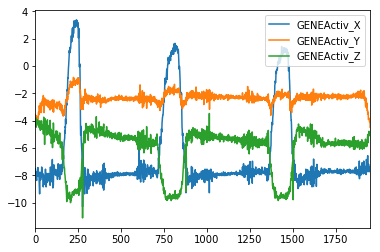

In [24]:
rawdata.iloc[:,1:4].plot()

In [25]:
rawdata.head()

,timestamp,GENEActiv_X,GENEActiv_Y,GENEActiv_Z,GENEActiv_Magnitude
0,1.434973e+09,-7.51189,-3.56766,-4.28453,9.35489
1,1.434973e+09,-7.55112,-3.95894,-4.05407,9.44077
2,1.434973e+09,-7.86689,-4.15409,-3.78537,9.66817
3,1.434973e+09,-7.86690,-4.27178,-4.13055,9.85889
4,1.434973e+09,-7.90612,-3.88050,-4.36101,9.82769
